In [50]:
# ===============================================================
# Milestone 5 - Part 1: Import Libraries
# ===============================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings("ignore")

print("✅ Libraries imported successfully.")


✅ Libraries imported successfully.


In [51]:
# ===============================================================
# Milestone 5 - Part 2: Load and Prepare Data
# ===============================================================

# Load dataset
data = pd.read_csv("cleaned_dynamic_pricing.csv")

# Normalize column names
data.columns = (
    data.columns.str.strip()
    .str.lower()
    .str.replace(" ", "_")
    .str.replace("-", "_")
)

# Detect target column automatically
target_candidates = [
    "optimal_price", "price", "fare", "predicted_price",
    "dynamic_price", "historical_cost_of_ride"
]

target_col = None
for c in target_candidates:
    if c in data.columns:
        target_col = c
        break

if target_col is None:
    raise KeyError(f"Target column not found. Available columns: {list(data.columns)}")

print(f"✅ Target column detected: {target_col}")

# Separate features and target
y = pd.to_numeric(data[target_col], errors="coerce")
X = data.drop(columns=[target_col])

# Drop rows with NaN target
mask = y.notna()
X, y = X.loc[mask], y.loc[mask]

# Train–test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Data split complete → Train: {X_train.shape}, Test: {X_test.shape}")

# Encode categorical features
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
if cat_cols:
    X_train_enc = pd.get_dummies(X_train, columns=cat_cols)
    X_test_enc = pd.get_dummies(X_test, columns=cat_cols)
    X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)
else:
    X_train_enc, X_test_enc = X_train.copy(), X_test.copy()

print("✅ Data prepared and encoded successfully.")


✅ Target column detected: historical_cost_of_ride
Data split complete → Train: (800, 9), Test: (200, 9)
✅ Data prepared and encoded successfully.


In [52]:
# ===============================================================
# Milestone 5 - Part 6A: XGBoost Hyperparameter Tuning
# ===============================================================

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='mae',
    random_state=42,
    tree_method='hist'
)

xgb_param_grid = {
    'n_estimators': [200, 400, 600, 800],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.85, 1.0],
    'colsample_bytree': [0.7, 0.85, 1.0],
    'reg_lambda': [0.5, 1, 1.5, 2.0]
}

print("🔍 Running RandomizedSearchCV for XGBoost (this may take time)...")

xgb_random = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=25,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

xgb_random.fit(X_train_enc, y_train)

print("✅ Best XGBoost parameters found:")
print(xgb_random.best_params_)

# Save best parameters
best_xgb_params = xgb_random.best_params_
joblib.dump(best_xgb_params, "best_xgb_params.pkl")
print("📦 Saved as best_xgb_params.pkl")


🔍 Running RandomizedSearchCV for XGBoost (this may take time)...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
✅ Best XGBoost parameters found:
{'subsample': 0.7, 'reg_lambda': 2.0, 'n_estimators': 600, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.85}
📦 Saved as best_xgb_params.pkl


In [53]:
# ===============================================================
# Milestone 5 - Part 6B: LightGBM Hyperparameter Tuning
# ===============================================================

lgb_model = lgb.LGBMRegressor(random_state=42)

lgb_param_grid = {
    'n_estimators': [300, 500, 800],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'num_leaves': [20, 31, 50, 80],
    'max_depth': [-1, 5, 7, 10],
    'subsample': [0.7, 0.85, 1.0],
    'colsample_bytree': [0.7, 0.85, 1.0],
    'reg_lambda': [0.5, 1, 1.5],
    'min_child_samples': [10, 20, 30]
}

print("🔍 Running RandomizedSearchCV for LightGBM (this may take time)...")

lgb_random = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=lgb_param_grid,
    n_iter=20,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

lgb_random.fit(X_train_enc, y_train)

print("✅ Best LightGBM parameters found:")
print(lgb_random.best_params_)

# Save best parameters
best_lgb_params = lgb_random.best_params_
joblib.dump(best_lgb_params, "best_lgb_params.pkl")
print("📦 Saved as best_lgb_params.pkl")


🔍 Running RandomizedSearchCV for LightGBM (this may take time)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 17
[LightGBM] [Info] Start training from score 370.729560
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

In [54]:
# ===============================================================
# Milestone 5 - Part 3: Train Final XGBoost Model Using Best Params
# ===============================================================

# Load tuned parameters
best_xgb_params = joblib.load("best_xgb_params.pkl")

best_xgb = xgb.XGBRegressor(
    **best_xgb_params,
    objective='reg:squarederror',
    eval_metric='mae',
    random_state=42,
    tree_method='hist'
)

print("⚙️ Training final XGBoost model...")
best_xgb.fit(X_train_enc, y_train)

# Evaluate
y_pred_xgb = best_xgb.predict(X_test_enc)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\n📊 Final XGBoost Model Performance:")
print(f"MAE  : {mae_xgb:.2f}")
print(f"RMSE : {rmse_xgb:.2f}")
print(f"R²   : {r2_xgb:.3f}")

# Save model
joblib.dump(best_xgb, "xgb_pricing_model.pkl")
joblib.dump(X_train_enc.columns.tolist(), "model_columns.pkl")
print("✅ XGBoost model and columns saved successfully.")


⚙️ Training final XGBoost model...

📊 Final XGBoost Model Performance:
MAE  : 53.36
RMSE : 70.28
R²   : 0.865
✅ XGBoost model and columns saved successfully.


In [55]:
# ===============================================================
# Milestone 5 - Part 4: Train Final LightGBM Model Using Best Params
# ===============================================================

# Load tuned parameters
best_lgb_params = joblib.load("best_lgb_params.pkl")

lgb_model = lgb.LGBMRegressor(**best_lgb_params, random_state=42)

print("⚙️ Training final LightGBM model...")
lgb_model.fit(X_train_enc, y_train)
y_pred_lgb = lgb_model.predict(X_test_enc)

# Evaluate
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb = r2_score(y_test, y_pred_lgb)

print("\n📊 Final LightGBM Model Performance:")
print(f"MAE  : {mae_lgb:.2f}")
print(f"RMSE : {rmse_lgb:.2f}")
print(f"R²   : {r2_lgb:.3f}")

joblib.dump(lgb_model, "lgb_pricing_model.pkl")
print("✅ LightGBM model saved successfully.")


⚙️ Training final LightGBM model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 17
[LightGBM] [Info] Start training from score 370.729560
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

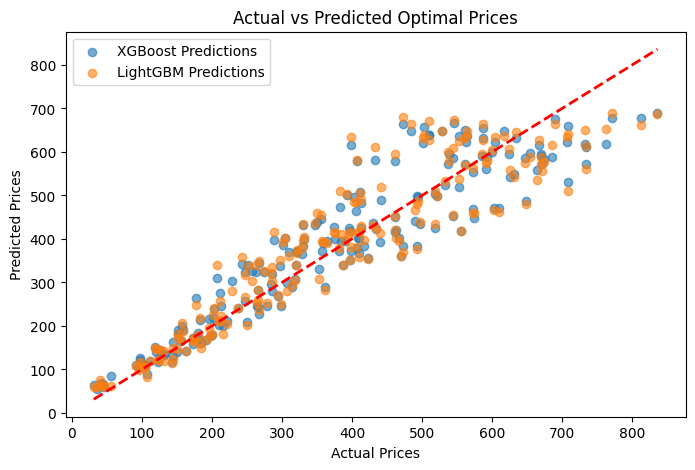


📊 Backtest Performance Metrics:
XGBoost  -> MSE: 4938.8355, RMSE: 70.2768, R²: 0.8645
LightGBM -> MSE: 5417.4164, RMSE: 73.6031, R²: 0.8514


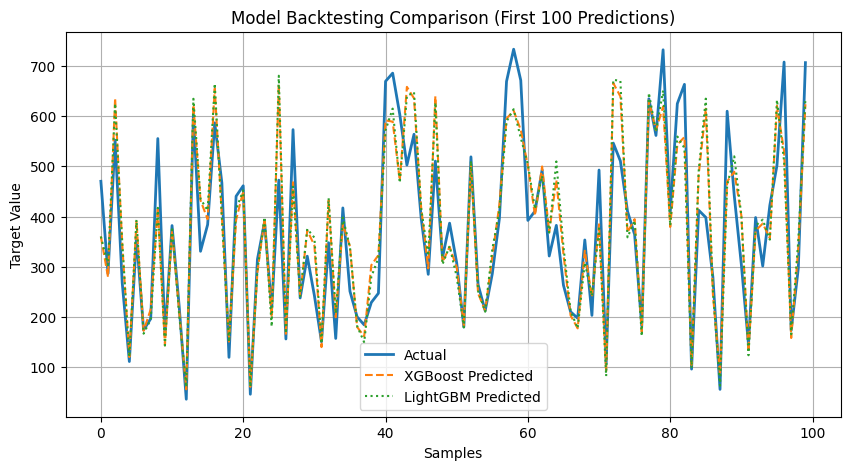

In [56]:
# ===============================================================
# Milestone 5 - Part 6: Visualizations
# ===============================================================

# ---------------------------
# Plot actual vs predicted (use encoded test set)
# ---------------------------
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred_xgb, alpha=0.6, label='XGBoost Predictions')
plt.scatter(y_test, y_pred_lgb, alpha=0.6, label='LightGBM Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Optimal Prices")
plt.legend()
plt.show()

# ---------------------------
# Backtest time series visual comparison (first 100 samples)
# ---------------------------
def backtest_model(model, X_enc, y_true):
    preds = model.predict(X_enc)
    return pd.DataFrame({'Actual': y_true.values, 'Predicted': preds})

xgb_backtest_results = backtest_model(best_xgb, X_test_enc, y_test)
lgb_backtest_results = backtest_model(lgb_model, X_test_enc, y_test)

def evaluate_backtest(results):
    mse = mean_squared_error(results['Actual'], results['Predicted'])
    rmse = np.sqrt(mse)
    r2 = r2_score(results['Actual'], results['Predicted'])
    return mse, rmse, r2

xgb_mse, xgb_rmse, xgb_r2 = evaluate_backtest(xgb_backtest_results)
lgb_mse, lgb_rmse, lgb_r2 = evaluate_backtest(lgb_backtest_results)

print("\n📊 Backtest Performance Metrics:")
print(f"XGBoost  -> MSE: {xgb_mse:.4f}, RMSE: {xgb_rmse:.4f}, R²: {xgb_r2:.4f}")
print(f"LightGBM -> MSE: {lgb_mse:.4f}, RMSE: {lgb_rmse:.4f}, R²: {lgb_r2:.4f}")

plt.figure(figsize=(10,5))
plt.plot(xgb_backtest_results['Actual'].values[:100], label='Actual', linewidth=2)
plt.plot(xgb_backtest_results['Predicted'].values[:100], label='XGBoost Predicted', linestyle='--')
plt.plot(lgb_backtest_results['Predicted'].values[:100], label='LightGBM Predicted', linestyle=':')
plt.title("Model Backtesting Comparison (First 100 Predictions)")
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.legend()
plt.grid(True)
plt.show()

In [57]:
# Evaluate the models by MSE, MAE, R2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

mse_lgb = mean_squared_error(y_test, y_pred_lgb)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print("\nXGBoost Model Performance:")
print(f"Mean Squared Error (MSE): {mse_xgb}")
print(f"Mean Absolute Error (MAE): {mae_xgb}")
print(f"R-squared (R2): {r2_xgb}")

print("\nLightGBM Model Performance:")
print(f"Mean Squared Error (MSE): {mse_lgb}")
print(f"Mean Absolute Error (MAE): {mae_lgb}")
print(f"R-squared (R2): {r2_lgb}")

# Compare actual and predicted values
import pandas as pd

results_df = pd.DataFrame({
    'Actual': y_test,
    'XGBoost Predicted': y_pred_xgb,
    'LightGBM Predicted': y_pred_lgb
})

print("\nActual vs Predicted Values:")
print(results_df)


XGBoost Model Performance:
Mean Squared Error (MSE): 4938.835512881077
Mean Absolute Error (MAE): 53.35960360075914
R-squared (R2): 0.8645439727967951

LightGBM Model Performance:
Mean Squared Error (MSE): 5417.416358294621
Mean Absolute Error (MAE): 55.09529547131333
R-squared (R2): 0.8514180730080303

Actual vs Predicted Values:
         Actual  XGBoost Predicted  LightGBM Predicted
521  470.269024         360.217651          360.264251
737  286.409294         279.797424          303.486828
740  552.269375         635.744812          625.114975
660  267.740417         345.067871          349.355166
411  111.112715         120.107658          120.362767
..          ...                ...                 ...
408  258.014460         326.089417          303.803252
332  412.255607         425.354523          430.185952
208  552.639771         518.959961          538.089972
613  544.602781         586.645874          608.340873
78   151.580404         190.866470          182.584999

[200 

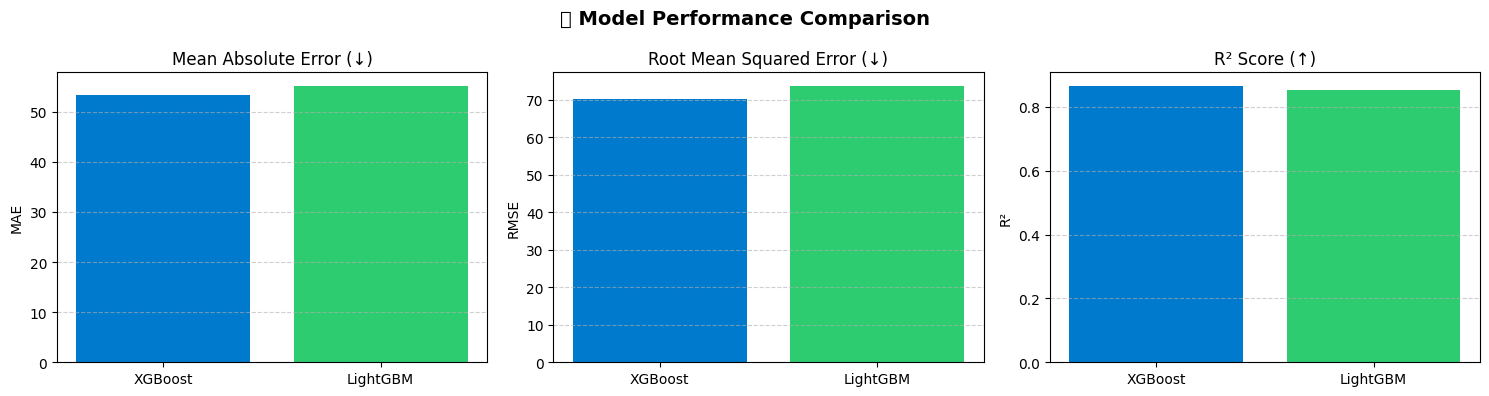

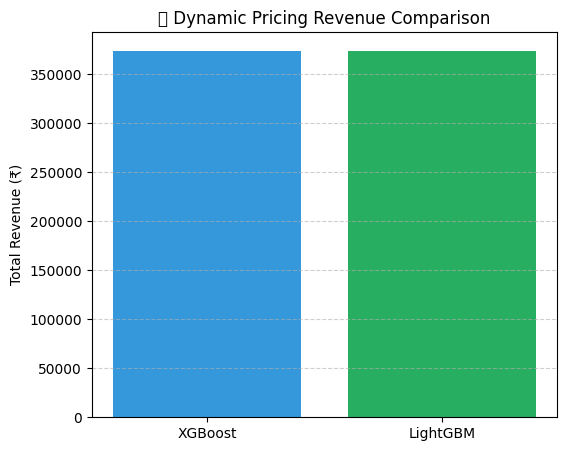


📊 Revenue Lift Summary:
XGBoost Revenue Lift : 0.24%
LightGBM Revenue Lift: 0.35%


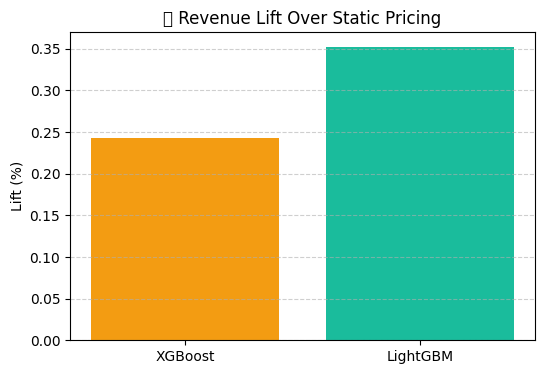

In [58]:
# ===============================================================
# Milestone 5 - Part 7: Model Performance Comparison Visualization 
# ===============================================================

import matplotlib.pyplot as plt
import numpy as np

# If static_rev or revenue values are missing (e.g. after restart), re-compute them safely
if 'static_rev' not in globals() or 'dyn_xgb_rev' not in globals() or 'dyn_lgb_rev' not in globals():
    print("⚠️ Revenue variables not found — recalculating from Part 5...")
    historical_data = data.copy()
    X_full = historical_data.drop(columns=[target_col])

    if cat_cols:
        X_full_enc = pd.get_dummies(X_full, columns=cat_cols)
        X_full_enc = X_full_enc.reindex(columns=X_train_enc.columns, fill_value=0)
    else:
        X_full_enc = X_full.copy()

    # Predictions
    historical_data["Predicted_XGB"] = best_xgb.predict(X_full_enc)
    historical_data["Predicted_LGB"] = lgb_model.predict(X_full_enc)

    if "units_sold" not in historical_data.columns:
        historical_data["units_sold"] = 1

    historical_data["Static_Revenue"] = historical_data[target_col] * historical_data["units_sold"]
    historical_data["Dynamic_Revenue_XGB"] = historical_data["Predicted_XGB"] * historical_data["units_sold"]
    historical_data["Dynamic_Revenue_LGB"] = historical_data["Predicted_LGB"] * historical_data["units_sold"]

    static_rev = historical_data["Static_Revenue"].sum()
    dyn_xgb_rev = historical_data["Dynamic_Revenue_XGB"].sum()
    dyn_lgb_rev = historical_data["Dynamic_Revenue_LGB"].sum()

# ----------------------------------------------------------------
# Collect metrics
# ----------------------------------------------------------------
metrics = {
    "MAE": [mae_xgb, mae_lgb],
    "RMSE": [rmse_xgb, rmse_lgb],
    "R²": [r2_xgb, r2_lgb],
    "Revenue (₹)": [dyn_xgb_rev, dyn_lgb_rev]
}

models = ["XGBoost", "LightGBM"]

# ------------------------------
# 📊 1. Error Metrics Comparison
# ------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("📈 Model Performance Comparison", fontsize=14, fontweight="bold")

axes[0].bar(models, metrics["MAE"], color=["#007acc", "#2ecc71"])
axes[0].set_title("Mean Absolute Error (↓)")
axes[0].set_ylabel("MAE")

axes[1].bar(models, metrics["RMSE"], color=["#007acc", "#2ecc71"])
axes[1].set_title("Root Mean Squared Error (↓)")
axes[1].set_ylabel("RMSE")

axes[2].bar(models, metrics["R²"], color=["#007acc", "#2ecc71"])
axes[2].set_title("R² Score (↑)")
axes[2].set_ylabel("R²")

for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# ------------------------------
# 💰 2. Revenue Comparison
# ------------------------------
plt.figure(figsize=(6,5))
plt.bar(models, [dyn_xgb_rev, dyn_lgb_rev], color=["#3498db", "#27ae60"])
plt.title("💰 Dynamic Pricing Revenue Comparison")
plt.ylabel("Total Revenue (₹)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# ------------------------------
# 🔍 3. Revenue Lift Summary
# ------------------------------
xgb_lift = ((dyn_xgb_rev / static_rev) - 1) * 100
lgb_lift = ((dyn_lgb_rev / static_rev) - 1) * 100

print("\n📊 Revenue Lift Summary:")
print(f"XGBoost Revenue Lift : {xgb_lift:.2f}%")
print(f"LightGBM Revenue Lift: {lgb_lift:.2f}%")

plt.figure(figsize=(6,4))
plt.bar(models, [xgb_lift, lgb_lift], color=["#f39c12", "#1abc9c"])
plt.title("📈 Revenue Lift Over Static Pricing")
plt.ylabel("Lift (%)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [59]:
# ===============================================================
# Milestone 5 - Part 8: Summary Report (Auto-Generated)
# ===============================================================

import pandas as pd

print("🧾 ===== AI : PriceOptima | Milestone 5 Summary Report =====\n")

# ----------------------------------------------------------------
# Load best hyperparameters (if available)
# ----------------------------------------------------------------
try:
    best_xgb_params = joblib.load("best_xgb_params.pkl")
except:
    best_xgb_params = "⚠️ Not Found (tuning not executed)"
try:
    best_lgb_params = joblib.load("best_lgb_params.pkl")
except:
    best_lgb_params = "⚠️ Not Found (tuning not executed)"

# ----------------------------------------------------------------
# Summary Table for Model Performance
# ----------------------------------------------------------------
summary_data = {
    "Model": ["XGBoost", "LightGBM"],
    "MAE": [round(mae_xgb, 2), round(mae_lgb, 2)],
    "RMSE": [round(rmse_xgb, 2), round(rmse_lgb, 2)],
    "R²": [round(r2_xgb, 3), round(r2_lgb, 3)],
    "Revenue (₹)": [round(dyn_xgb_rev, 2), round(dyn_lgb_rev, 2)],
    "Revenue Lift (%)": [
        round(((dyn_xgb_rev/static_rev)-1)*100, 2),
        round(((dyn_lgb_rev/static_rev)-1)*100, 2)
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# ----------------------------------------------------------------
# Display Hyperparameters
# ----------------------------------------------------------------
print("\n🔧 Best XGBoost Hyperparameters:")
print(best_xgb_params)

print("\n🔧 Best LightGBM Hyperparameters:")
print(best_lgb_params)

# ----------------------------------------------------------------
# Recommendations
# ----------------------------------------------------------------
best_model = (
    "XGBoost"
    if summary_df.loc[0, "Revenue Lift (%)"] >= summary_df.loc[1, "Revenue Lift (%)"]
    else "LightGBM"
)
print(f"\n🏆 Recommended Model for Deployment: {best_model}")

print("\n✅ Milestone 5 Completed Successfully!")
print("--------------------------------------------------------------")


🧾 ===== AI : PriceOptima | Milestone 5 Summary Report =====

   Model   MAE  RMSE    R²  Revenue (₹)  Revenue Lift (%)
 XGBoost 53.36 70.28 0.865    373406.93              0.24
LightGBM 55.10 73.60 0.851    373814.98              0.35

🔧 Best XGBoost Hyperparameters:
{'subsample': 0.7, 'reg_lambda': 2.0, 'n_estimators': 600, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.85}

🔧 Best LightGBM Hyperparameters:
{'subsample': 0.85, 'reg_lambda': 1.5, 'num_leaves': 31, 'n_estimators': 500, 'min_child_samples': 30, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 1.0}

🏆 Recommended Model for Deployment: LightGBM

✅ Milestone 5 Completed Successfully!
--------------------------------------------------------------
